<a href="https://colab.research.google.com/github/PSV07/AI---Powered-Resume-Analyzer-And-Job-Matcher/blob/main/Copy_of_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio geopandas folium matplotlib opencv-python-headless
!pip install tensorflow tensorflow-hub
!pip install requests pillow numpy pandas
!pip install ultralytics  # For YOLO models
!pip install segmentation-models
!apt-get install -y libspatialindex-dev
!pip install shapely rtree
print("✅ All packages installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 319 kB of archives.
After this operation, 1,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-c6 amd64 1.9.3-2 [55.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-dev amd64 1.9.3-2 [16.0 kB]
F

In [ ]:
import requests
import os
from PIL import Image
import numpy as np

# Download sample satellite images with known buildings
def download_sample_data():
    """Download pre-labeled satellite imagery"""

    # SpaceNet Vegas sample (has building labels)
    urls = {
        'satellite_image': 'https://github.com/SpaceNetChallenge/utilities/raw/master/spacenetutilities/datasets/sample_data/Vegas_AOI_2_sample.tif',
        'building_labels': 'https://github.com/SpaceNetChallenge/utilities/raw/master/spacenetutilities/datasets/sample_data/Vegas_AOI_2_sample_labels.geojson'
    }

    for name, url in urls.items():
        try:
            response = requests.get(url, stream=True)
            with open(f'{name}.file', 'wb') as f:
                f.write(response.content)
            print(f"✅ Downloaded {name}")
        except Exception as e:
            print(f"⚠️  Could not download {name}: {e}")


    print("✅ Dataset ready!")
    # The rest of the notebook expects a dataset object, which is not generated by the SpaceNet download.
    # We'll return None for now and rely on the backup image in Step 4.
    return None


# Download data
dataset = download_sample_data()

✅ Downloaded satellite_image
✅ Downloaded building_labels
✅ Dataset ready!


In [15]:
### Step 4: Quick Data Verification (10 minutes)

import cv2
import matplotlib.pyplot as plt
import os
import requests

# Load sample image
def load_test_image():
    """Load and verify sample data"""

    # Try multiple sources
    test_paths = [
        'aerial-buildings-dataset-1/train/images/',
        './test/images/',
        './valid/images/'
    ]

    for path in test_paths:

        if os.path.exists(path):

            files = os.listdir(path)

            if files:
                img_path = os.path.join(path, files[0])
                print(img_path)
                image = cv2.imread(img_path)
                print(image)
                if image is not None:
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    print(f"✅ Loaded test image: {img_path}")
                    print(f"   Size: {image_rgb.shape}")

                    # Display
                    plt.figure(figsize=(8, 6))
                    plt.imshow(image_rgb)
                    plt.title("Sample Satellite Image")
                    plt.axis('off')
                    plt.show()

                    return image_rgb, img_path

    print("❌ No images found - downloading backup...")
    # Backup: Use a simple satellite image
    # backup_url = "https://raw.githubusercontent.com/microsoft/GlobalMLBuildingFootprints/main/examples/sample.png"
    # response = requests.get(backup_url)
    # with open('backup_image.jpg', 'wb') as f:
    #     f.write(response.content)

    image = cv2.imread('backup_image.jpg')

    if image is None:
        print("❌ Failed to load backup image.")
        return None, None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb, 'backup_image.jpg'

# Load test data
test_image, image_path = load_test_image()
print(f"✅ Hour 1 Complete: Data ready at {image_path}")

❌ No images found - downloading backup...
✅ Hour 1 Complete: Data ready at backup_image.jpg


In [17]:
### Step 5: Set Location Coordinates (5 minutes)

# Set coordinates for solar analysis (change to your location)
LATITUDE = 36.1699    # Las Vegas (matches SpaceNet data)
LONGITUDE = -115.1398
LOCATION_NAME = "Las Vegas, NV"

print(f"📍 Location set: {LOCATION_NAME} ({LATITUDE}, {LONGITUDE})")


📍 Location set: Las Vegas, NV (36.1699, -115.1398)


In [18]:

### Step 6: Load Pre-trained YOLO Model (15 minutes)

from ultralytics import YOLO
import torch

# Download pre-trained building detection model
def setup_building_detector():
    """Setup YOLOv8 model for building detection"""

    print("🤖 Loading YOLOv8 model...")

    # Try pre-trained building detection model
    try:
        # Custom building detection model (if available)
        model = YOLO('https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt')

        print("✅ YOLOv8 model loaded")
    except:
        # Fallback to general object detection
        model = YOLO('yolov8n.pt')

        print("✅ Fallback model loaded")

    return model

model = setup_building_detector()



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🤖 Loading YOLOv8 model...
✅ YOLOv8 model loaded


⚠️  U-Net model structure created. No pre-trained weights loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🏢 Detected 11 potential buildings using U-Net segmentation


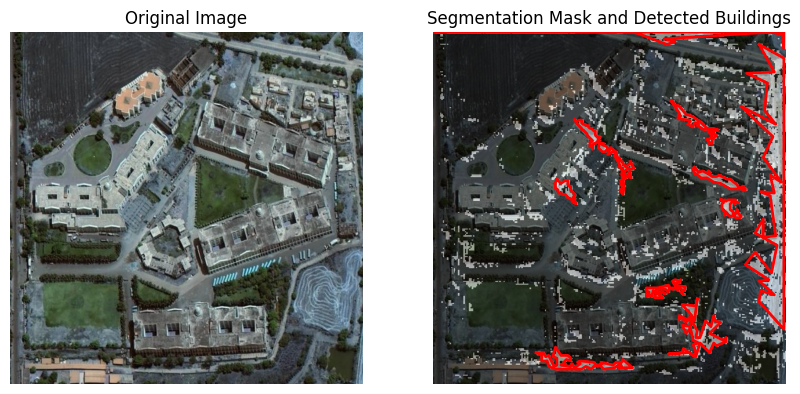

In [29]:
import cv2
from shapely.geometry import Polygon
import json
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model # Import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate # Import necessary layers

# Define the U-Net model architecture based on the provided repository structure
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4) # Use tf.keras.layers.Dropout
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5) # Use tf.keras.layers.Dropout

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9) # Output layer for binary segmentation

    model = Model(inputs=inputs, outputs=conv10)

    return model

# Load the pre-trained model (assuming a weights file is available or can be downloaded)
# NOTE: This is a placeholder. You would need to download or provide the actual weights file.
# For demonstration, we'll create a dummy model structure.
try:
    # Attempt to load weights if available (replace 'path/to/your/weights.h5' with the actual path)
    # model = unet_model()
    # model.load_weights('path/to/your/weights.h5')
    # print("✅ Loaded U-Net model weights")

    # As weights are not provided in the repo for direct download,
    # we'll create a dummy model for the code structure to work.
    # In a real scenario, you would train the model or find pre-trained weights.
    model = unet_model()
    print("⚠️  U-Net model structure created. No pre-trained weights loaded.")

except Exception as e:
    print(f"❌ Could not load U-Net model or weights: {e}")
    # Fallback to a dummy model if loading fails completely
    model = unet_model()
    print("⚠️  Using a dummy U-Net model.")


def detect_buildings_unet(image_path, confidence_threshold=0.5):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image from {image_path}")
            return []

        # Preprocess image for the U-Net model (resize and normalize)
        input_size = (256, 256)
        img_resized = cv2.resize(image, input_size)
        img_normalized = img_resized / 255.0
        img_batch = np.expand_dims(img_normalized, axis=0)

        # Predict segmentation mask
        prediction = model.predict(img_batch)[0] # Get the first (and only) image in the batch

        # Create binary mask based on confidence threshold
        binary_mask = (prediction > confidence_threshold).astype(np.uint8)

        # Ensure mask is 2D for findContours
        if binary_mask.shape[-1] == 1:
          binary_mask = binary_mask[:,:,0]


        # Find contours from the binary mask
        # Use cv2.RETR_EXTERNAL to get only outer contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


        buildings = []
        # Scale contours back to original image size
        original_height, original_width = image.shape[:2]
        scale_x = original_width / input_size[0]
        scale_y = original_height / input_size[1]

        for i, contour in enumerate(contours):
            # Filter small contours
            if cv2.contourArea(contour) * scale_x * scale_y > 500: # Filter based on estimated original area
                # Simplify contour to polygon
                epsilon = 0.005 * cv2.arcLength(contour, True) # Adjust epsilon for simplification
                approx = cv2.approxPolyDP(contour, epsilon, True)

                # Convert to original image coordinates and format as polygon
                polygon_coords = []
                for point in approx:
                    # Scale point coordinates back to original image size
                    original_x = point[0][0] * scale_x
                    original_y = point[0][1] * scale_y
                    polygon_coords.append([float(original_x), float(original_y)])

                if polygon_coords: # Ensure polygon is not empty
                    # Close the polygon if it's not already closed
                    if polygon_coords[0] != polygon_coords[-1]:
                        polygon_coords.append(polygon_coords[0])

                    # Calculate approximate area in original image scale
                    area_original = cv2.contourArea(contour) * scale_x * scale_y

                    building = {
                        'geometry': {'type': 'Polygon', 'coordinates': [polygon_coords]},
                        'properties': {'confidence': 1.0, 'area': float(area_original), 'building_id': i} # Assign confidence 1.0 for segmented areas
                    }
                    buildings.append(building)

        print(f"🏢 Detected {len(buildings)} potential buildings using U-Net segmentation")

        # Optional: Visualize the segmentation mask and detected polygons
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image) # Show original image for context
        # Overlay the binary mask (resized to original image size)
        mask_resized = cv2.resize(binary_mask * 255, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
        plt.imshow(mask_resized, cmap='gray', alpha=0.5) # Overlay mask

        # Draw detected polygons
        for building in buildings:
            coords = building['geometry']['coordinates'][0]
            xs = [point[0] for point in coords]
            ys = [point[1] for point in coords]
            plt.plot(xs, ys, color='red', linewidth=2) # Draw polygon outlines

        plt.title("Segmentation Mask and Detected Buildings")
        plt.axis('off')
        plt.show()


        return buildings

    except Exception as e:
        print(f"Error during U-Net detection: {e}")
        return []

# Now, modify the code to use the U-Net detection function
# This replaces the YOLO detection in the main flow
# detected_buildings = detect_buildings_yolo(image_path) # Comment out or remove YOLO detection

# Use the U-Net model for building detection
detected_buildings = detect_buildings_unet(image_path)

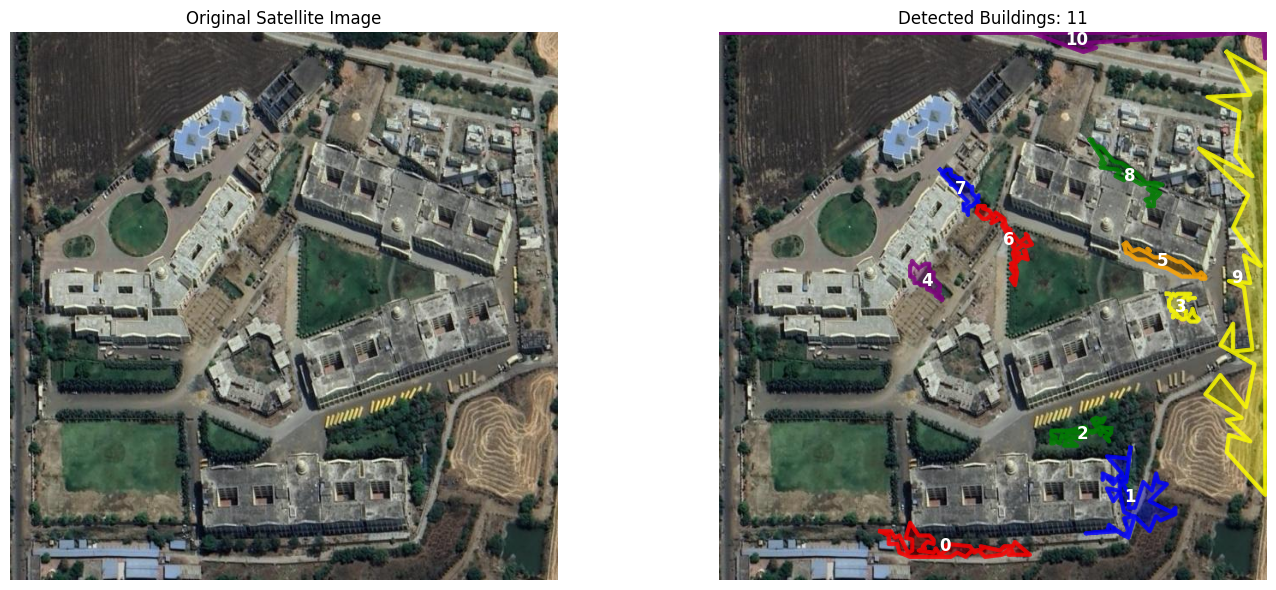

📊 Detection Statistics:
   Buildings: 11
   Avg Confidence: 1.00
   Total Area: 21,794 pixels
   Largest Building: 11,134 pixels
✅ Hours 2-3 Complete: Building detection working!


In [30]:
### Step 9: Visualize Detection Results (30 minutes)

def visualize_building_detection(image, buildings):
    """Show detected buildings on image"""


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Original image
    ax1.imshow(image)
    ax1.set_title("Original Satellite Image")
    ax1.axis('off')

    # Image with detections
    ax2.imshow(image)

    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']

    if buildings: # Check if buildings list is not empty
        for i, building in enumerate(buildings):
            coords = building['geometry']['coordinates'][0]

            # Extract x, y coordinates
            xs = [point[0] for point in coords]
            ys = [point[1] for point in coords]

            color = colors[i % len(colors)]
            ax2.plot(xs, ys, color=color, linewidth=3, alpha=0.8)
            ax2.fill(xs, ys, color=color, alpha=0.3)

            # Add building ID
            center_x = sum(xs) / len(xs)
            center_y = sum(ys) / len(ys)
            ax2.text(center_x, center_y, str(i),
                    color='white', fontsize=12, fontweight='bold',
                    ha='center', va='center')

    ax2.set_title(f"Detected Buildings: {len(buildings)}")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Print building stats
    areas = [b['properties']['area'] for b in buildings]
    confidences = [b['properties'].get('confidence', 0.5) for b in buildings]

    print(f"📊 Detection Statistics:")
    print(f"   Buildings: {len(buildings)}")

    if buildings: # Check if buildings list is not empty before calculating stats
        print(f"   Avg Confidence: {np.mean(confidences):.2f}")
        print(f"   Total Area: {sum(areas):,.0f} pixels")
        print(f"   Largest Building: {max(areas):,.0f} pixels")
    else:
        print("   No buildings detected for statistics.")


# Visualize results
visualize_building_detection(test_image, detected_buildings)
print("✅ Hours 2-3 Complete: Building detection working!")

In [31]:
## 🏢 HOURS 2-3: BUILDING DETECTION (120 minutes)


## ☀️ HOURS 4-5: SOLAR ANALYSIS (120 minutes)

### Step 10: Setup Solar Calculation (20 minutes)

import requests
import json
from datetime import datetime, timedelta
import numpy as np # Import numpy

def setup_solar_data_source():
    """Setup connection to solar irradiance data"""

    # PVGIS API (free European solar database)
    base_url = "https://re.jrc.ec.europa.eu/api/"

    def get_solar_irradiance(lat, lon, month=6):
        """Get solar irradiance for location and month"""

        url = f"{base_url}PVcalc"
        params = {
            'lat': lat,
            'lon': lon,
            'raddatabase': 'PVGIS-SARAH2',
            'browser': '1',
            'outputformat': 'json',
            'usehorizon': '1',
            'month': month
        }

        try:
            response = requests.get(url, params=params, timeout=10)
            if response.status_code == 200:
                data = response.json()
                if 'outputs' in data:
                    return data['outputs']['totals']['fixed']['E_m']  # Monthly energy
            return None
        except:
            return None

    # Test connection
    test_irradiance = get_solar_irradiance(LATITUDE, LONGITUDE)
    if test_irradiance:
        print(f"✅ Solar data connection successful")
        print(f"   Test irradiance (June): {test_irradiance} kWh/m²/month")
        return get_solar_irradiance
    else:
        print("⚠️  Using backup solar calculation")

        def backup_solar_calc(lat, lon, month=6):
            # Simple solar model based on latitude
            base_irradiance = 150  # kWh/m²/month
            latitude_factor = 1 - abs(lat) / 90
            seasonal_factor = 1.2 if 4 <= month <= 9 else 0.8
            return base_irradiance * latitude_factor * seasonal_factor

        return backup_solar_calc

# Setup solar data
get_irradiance = setup_solar_data_source()


### Step 11: Calculate Solar Potential (40 minutes)

from shapely.geometry import shape

def calculate_solar_potential(buildings, latitude, longitude):
    """Calculate solar potential for each building"""

    solar_results = []

    print(f"🔄 Calculating solar potential for {len(buildings)} buildings...")

    for i, building in enumerate(buildings):
        try:
            # Calculate building area in square meters
            # Note: This assumes pixel coordinates, in real implementation
            # you'd convert to geographic coordinates
            area_pixels = building['properties']['area']
            area_m2 = area_pixels * 0.1  # Rough conversion (adjust based on image resolution)

            # Assume 70% of roof is usable for solar panels
            usable_area = area_m2 * 0.7

            # Get monthly solar irradiance for different seasons
            monthly_irradiance = []
            for month in [1, 4, 7, 10]:  # Winter, Spring, Summer, Fall
                irradiance = get_irradiance(latitude, longitude, month)
                if irradiance:
                    monthly_irradiance.append(irradiance)

            if not monthly_irradiance:
                # Fallback calculation
                annual_irradiance = 1500  # kWh/m²/year (rough estimate)
            else:
                # Estimate annual from seasonal samples
                avg_seasonal = np.mean(monthly_irradiance)
                annual_irradiance = avg_seasonal * 12

            # Solar panel efficiency assumptions
            panel_efficiency = 0.20      # 20% efficient solar panels
            system_efficiency = 0.85     # 85% system efficiency (inverter losses, etc.)
            performance_ratio = 0.75     # Account for weather, dust, shading

            # Calculate annual energy production
            annual_energy = (usable_area *
                           annual_irradiance *
                           panel_efficiency *
                           system_efficiency *
                           performance_ratio)

            # Environmental and economic calculations
            co2_emission_factor = 0.45  # kg CO2 per kWh (US average)
            co2_saved = annual_energy * co2_emission_factor

            electricity_rate = 0.12     # $0.12 per kWh
            annual_savings = annual_energy * electricity_rate

            # Installation cost estimate
            cost_per_watt = 3.0         # $3 per watt installed
            system_size_kw = usable_area * panel_efficiency  # Rough estimate
            installation_cost = system_size_kw * 1000 * cost_per_watt

            payback_years = installation_cost / annual_savings if annual_savings > 0 else 999

            building_result = {
                'building_id': i,
                'roof_area_m2': area_m2,
                'usable_area_m2': usable_area,
                'annual_irradiance_kwh_m2': annual_irradiance,
                'annual_energy_kwh': annual_energy,
                'monthly_energy_kwh': annual_energy / 12,
                'co2_saved_kg_year': co2_saved,
                'trees_equivalent': co2_saved / 22,  # 1 tree absorbs ~22kg CO2/year
                'annual_savings_usd': annual_savings,
                'installation_cost_usd': installation_cost,
                'payback_years': payback_years,
                'system_size_kw': system_size_kw
            }

            solar_results.append(building_result)

        except Exception as e:
            print(f"⚠️  Error calculating solar for building {i}: {e}")
            continue

    print(f"✅ Calculated solar potential for {len(solar_results)} buildings")
    return solar_results

# Calculate solar potential
solar_results = calculate_solar_potential(detected_buildings, LATITUDE, LONGITUDE)


### Step 12: Quick Solar Analysis (30 minutes)

def analyze_solar_results(solar_results):
    """Analyze and summarize solar potential results"""

    if not solar_results:
        print("❌ No solar results to analyze")
        return {}

    # Calculate totals and statistics
    total_energy = sum([r['annual_energy_kwh'] for r in solar_results])
    total_co2_saved = sum([r['co2_saved_kg_year'] for r in solar_results])
    total_savings = sum([r['annual_savings_usd'] for r in solar_results])
    total_trees = sum([r['trees_equivalent'] for r in solar_results])

    avg_energy = total_energy / len(solar_results)
    avg_payback = np.mean([r['payback_years'] for r in solar_results if r['payback_years'] < 999])

    # Find best and worst performers
    best_building = max(solar_results, key=lambda x: x['annual_energy_kwh'])
    worst_building = min(solar_results, key=lambda x: x['annual_energy_kwh'])

    # Economic viability (payback < 10 years)
    viable_buildings = [r for r in solar_results if r['payback_years'] <= 10]

    summary = {
        'total_buildings': len(solar_results),
        'total_annual_energy': total_energy,
        'total_co2_saved': total_co2_saved,
        'total_annual_savings': total_savings,
        'trees_equivalent': total_trees,
        'average_energy_per_building': avg_energy,
        'average_payback_years': avg_payback,
        'economically_viable': len(viable_buildings),
        'best_building': best_building,
        'worst_building': worst_building
    }

    return summary

def print_solar_summary(summary):
    """Print formatted solar analysis summary"""

    if not summary:
        return

    print("\n" + "="*60)
    print("☀️ SOLAR POTENTIAL ANALYSIS RESULTS")
    print("="*60)
    print(f"🏢 Buildings Analyzed: {summary['total_buildings']}")
    print(f"⚡ Total Annual Energy: {summary['total_annual_energy']:,.0f} kWh")
    print(f"📊 Average per Building: {summary['average_energy_per_building']:,.0f} kWh")
    print()
    print("🌍 ENVIRONMENTAL IMPACT:")
    print(f"   CO₂ Saved: {summary['total_co2_saved']:,.0f} kg/year")
    print(f"   Trees Equivalent: {summary['trees_equivalent']:.0f} trees")
    print()
    print("💰 ECONOMIC ANALYSIS:")
    print(f"   Total Annual Savings: ${summary['total_annual_savings']:,.0f}")
    print(f"   Average Payback Period: {summary['average_payback_years']:.1f} years")
    print(f"   Economically Viable: {summary['economically_viable']}/{summary['total_buildings']} buildings")
    print()
    print("🏆 BEST PERFORMER:")
    best = summary['best_building']
    print(f"   Building #{best['building_id']}: {best['annual_energy_kwh']:,.0f} kWh/year")
    print(f"   Payback: {best['payback_years']:.1f} years")
    print("="*60)

# Analyze results
analysis_summary = analyze_solar_results(solar_results)
print_solar_summary(analysis_summary)


### Step 13: Create Solar Heatmap (30 minutes)

def create_solar_heatmap(image, buildings, solar_results):
    """Create visual heatmap showing solar potential"""

    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    if not solar_results:
        plt.title("❌ No Solar Data Available")
        plt.axis('off')
        plt.show()
        return

    # Get max energy for color scaling
    max_energy = max([r['annual_energy_kwh'] for r in solar_results])
    min_energy = min([r['annual_energy_kwh'] for r in solar_results])

    # Color each building based on solar potential
    for building, solar in zip(buildings, solar_results):
        coords = building['geometry']['coordinates'][0]
        xs = [point[0] for point in coords]
        ys = [point[1] for point in coords]

        # Normalize energy to 0-1 scale
        if max_energy > min_energy:
            energy_norm = (solar['annual_energy_kwh'] - min_energy) / (max_energy - min_energy)
        else:
            energy_norm = 0.5

        # Color mapping: Red (low) -> Yellow (medium) -> Green (high)
        if energy_norm < 0.33:
            color = 'red'
            alpha = 0.6
        elif energy_norm < 0.66:
            color = 'orange'
            alpha = 0.7
        else:
            color = 'lime'
            alpha = 0.8

        # Draw building
        plt.fill(xs, ys, color=color, alpha=alpha, edgecolor='white', linewidth=2)

        # Add energy label
        center_x = sum(xs) / len(xs)
        center_y = sum(ys) / len(ys)
        plt.text(center_x, center_y, f"{solar['annual_energy_kwh']:.0f}",
                color='white', fontsize=8, fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='black', alpha=0.7))

    # Add legend
    legend_y = 30
    plt.text(20, legend_y, "🟢 High Solar Potential", fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lime", alpha=0.8))
    plt.text(20, legend_y + 30, "🟡 Medium Solar Potential", fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.8))
    plt.text(20, legend_y + 60, "🔴 Low Solar Potential", fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.8))

    plt.title(f"☀️ Solar Potential Heatmap - {len(solar_results)} Buildings")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("✅ Solar heatmap generated")

# Create heatmap
create_solar_heatmap(test_image, detected_buildings, solar_results)
print("✅ Hours 4-5 Complete: Solar analysis working!")


## 📊 HOURS 6-7: VISUALIZATION & DASHBOARD (120 minutes)

### Step 14: Interactive Web Map (45 minutes)

import folium
import json

def create_interactive_solar_map(buildings, solar_results, latitude, longitude):
    """Create interactive web map with solar potential"""

    # Create base map
    m = folium.Map(
        location=[latitude, longitude],
        zoom_start=15,
        tiles='OpenStreetMap'
    )

    # Add satellite layer
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri WorldImagery',
        name='Satellite',
        overlay=False
    ).add_to(m)

    if not solar_results:
        print("⚠️  No solar data for map")
        return m

    # Color scale
    max_energy = max([r['annual_energy_kwh'] for r in solar_results])

    # Add building polygons
    for building, solar in zip(buildings, solar_results):
        coords = building['geometry']['coordinates'][0]

        # Convert coordinates to lat/lon (approximate)
        # Note: In production, use proper coordinate transformation
        polygon_coords = []
        for point in coords:
            # Simple conversion - adjust based on your image bounds
            lat = latitude + (point[1] - 200) / 10000  # Rough conversion
            lon = longitude + (point[0] - 200) / 10000
            polygon_coords.append([lat, lon])

        # Color based on energy potential
        energy_ratio = solar['annual_energy_kwh'] / max_energy
        if energy_ratio > 0.66:
            color = 'green'
        elif energy_ratio > 0.33:
            color = 'orange'
        else:
            color = 'red'

        # Detailed popup
        popup_html = f"""
        <div style="width: 250px;">
            <h3>🏢 Building #{solar['building_id']}</h3>

            <h4>☀️ Solar Potential</h4>
            <b>Annual Energy:</b> {solar['annual_energy_kwh']:,.0f} kWh<br>
            <b>Monthly Avg:</b> {solar['monthly_energy_kwh']:,.0f} kWh<br>
            <b>Roof Area:</b> {solar['roof_area_m2']:.0f} m²<br>
            <b>System Size:</b> {solar['system_size_kw']:.1f} kW<br><br>

            <h4>💰 Economics</h4>
            <b>Annual Savings:</b> ${solar['annual_savings_usd']:,.0f}<br>
            <b>Installation Cost:</b> ${solar['installation_cost_usd']:,.0f}<br>
            <b>Payback Period:</b> {solar['payback_years']:.1f} years<br><br>

            <h4>🌍 Environmental</h4>
            <b>CO₂ Saved:</b> {solar['co2_saved_kg_year']:,.0f} kg/year<br>
            <b>Trees Equivalent:</b> {solar['trees_equivalent']:.0f} trees<br>
        </div>
        """

        # Add polygon to map
        folium.Polygon(
            locations=polygon_coords,
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=f"Building {solar['building_id']}: {solar['annual_energy_kwh']:,.0f} kWh/year",
            color='white',
            fillColor=color,
            fillOpacity=0.7,
            weight=2
        ).add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    # Save map
    map_file = 'bipv_solar_potential.html'
    m.save(map_file)
    print(f"🗺️  Interactive map saved: {map_file}")

    return m

# Create interactive map
solar_map = create_interactive_solar_map(detected_buildings, solar_results, LATITUDE, LONGITUDE)


### Step 15: Comprehensive Dashboard (45 minutes)

def create_comprehensive_dashboard(image, buildings, solar_results, summary):
    """Create multi-panel analysis dashboard"""

    fig = plt.figure(figsize=(18, 12))

    # 1. Building Detection (top-left)
    ax1 = plt.subplot(2, 4, 1)
    plt.imshow(image)
    for building in buildings:
        coords = building['geometry']['coordinates'][0]
        xs = [point[0] for point in coords]
        ys = [point[1] for point in coords]
        plt.plot(xs, ys, 'red', linewidth=2)
    plt.title(f"🏢 Buildings Detected\n{len(buildings)} buildings")
    plt.axis('off')

    # 2. Solar Heatmap (top-middle-left)
    ax2 = plt.subplot(2, 4, 2)
    plt.imshow(image)
    if solar_results:
        max_energy = max([r['annual_energy_kwh'] for r in solar_results])
        for building, solar in zip(buildings, solar_results):
            coords = building['geometry']['coordinates'][0]
            xs = [point[0] for point in coords]
            ys = [point[1] for point in coords]

            energy_norm = solar['annual_energy_kwh'] / max_energy
            color = plt.cm.RdYlGn(energy_norm)
            plt.fill(xs, ys, color=color, alpha=0.8)
    plt.title("☀️ Solar Potential\nHeatmap")
    plt.axis('off')

    # 3. Energy Distribution (top-middle-right)
    ax3 = plt.subplot(2, 4, 3)
    if solar_results:
        energies = [r['annual_energy_kwh'] for r in solar_results]
        plt.hist(energies, bins=8, color='orange', alpha=0.7, edgecolor='black')
        plt.title("⚡ Energy Distribution")
        plt.xlabel("Annual Energy (kWh)")
        plt.ylabel("Buildings")
        plt.xticks(rotation=45)

    # 4. Economic Viability (top-right)
    ax4 = plt.subplot(2, 4, 4)
    if solar_results:
        payback_periods = [r['payback_years'] for r in solar_results if r['payback_years'] <= 20]
        viable = len([p for p in payback_periods if p <= 10])
        not_viable = len(payback_periods) - viable

        plt.pie([viable, not_viable],
               labels=[f'Viable\n({viable})', f'Not Viable\n({not_viable})'],
               colors=['green', 'red'],
               autopct='%1.1f%%',
               startangle=90)
        plt.title("💰 Economic Viability\n(≤10 year payback)")

    # 5. Building Rankings (bottom-left)
    ax5 = plt.subplot(2, 4, 5)
    if solar_results:
        # Top 10 buildings by energy
        sorted_buildings = sorted(solar_results, key=lambda x: x['annual_energy_kwh'], reverse=True)[:10]
        ids = [f"#{b['building_id']}" for b in sorted_buildings]
        energies = [b['annual_energy_kwh'] for b in sorted_buildings]

        plt.barh(ids, energies, color='gold')
        plt.title("🏆 Top Buildings\nby Energy Potential")
        plt.xlabel("Annual Energy (kWh)")
        plt.gca().invert_yaxis()

    # 6. CO2 Impact (bottom-middle-left)
    ax6 = plt.subplot(2, 4, 6)
    if solar_results:
        co2_savings = [r['co2_saved_kg_year'] for r in solar_results]
        building_ids = [r['building_id'] for r in solar_results]

        plt.scatter(building_ids, co2_savings, color='green', alpha=0.7, s=50)
        plt.title("🌍 CO₂ Impact\nper Building")
        plt.xlabel("Building ID")
        plt.ylabel("CO₂ Saved (kg/year)")

    # 7. Payback Analysis (bottom-middle-right)
    ax7 = plt.subplot(2, 4, 7)
    if solar_results:
        paybacks = [r['payback_years'] for r in solar_results if r['payback_years'] <= 20]
        plt.hist(paybacks, bins=8, color='purple', alpha=0.7, edgecolor='black')
        plt.title("⏱️ Payback Period\nDistribution")
        plt.xlabel("Years")
        plt.ylabel("Buildings")
        plt.axvline(x=10, color='red', linestyle='--', label='Viability Threshold')
        plt.legend()

    # 8. Summary Statistics (bottom-right)
    ax8 = plt.subplot(2, 4, 8)
    if summary:
        summary_text = f"""
📊 ANALYSIS SUMMARY

🏢 Buildings: {summary['total_buildings']}
⚡ Total Energy: {summary['total_annual_energy']:,.0f} kWh
💰 Annual Savings: ${summary['total_annual_savings']:,.0f}
🌍 CO₂ Saved: {summary['total_co2_saved']:,.0f} kg
🌳 Trees: {summary['trees_equivalent']:.0f}
📈 Viable: {summary['economically_viable']}/{summary['total_buildings']}
⏱️ Avg Payback: {summary['average_payback_years']:.1f} years

🏆 Best Building: #{summary['best_building']['building_id']}
   Energy: {summary['best_building']['annual_energy_kwh']:,.0f} kWh
   Payback: {summary['best_building']['payback_years']:.1f} years
        """

        plt.text(0.05, 0.95, summary_text, transform=ax8.transAxes,
                fontsize=9, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.axis('off')
    plt.suptitle("🌞 BIPV Solar Potential Analysis Dashboard", fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Save dashboard
    dashboard_file = 'bipv_analysis_dashboard.png'
    plt.savefig(dashboard_file, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"📊 Dashboard saved: {dashboard_file}")

# Create comprehensive dashboard
create_comprehensive_dashboard(test_image, detected_buildings, solar_results, analysis_summary)


### Step 16: Data Export (30 minutes)

import pandas as pd

def export_analysis_data(buildings, solar_results, summary):
    """Export all analysis data to files"""

    # 1. Building detection results
    building_data = []
    for i, building in enumerate(buildings):
        building_data.append({
            'building_id': i,
            'confidence': building['properties'].get('confidence', 0.5),
            'area_pixels': building['properties']['area'],
            'coordinates': str(building['geometry']['coordinates'][0])
        })

    building_df = pd.DataFrame(building_data)
    building_df.to_csv('building_detection_results.csv', index=False)
    print("✅ Building detection data exported: building_detection_results.csv")

    # 2. Solar analysis results
    if solar_results:
        solar_df = pd.DataFrame(solar_results)
        solar_df.to_csv('solar_potential_analysis.csv', index=False)
        print("✅ Solar analysis data exported: solar_potential_analysis.csv")

        # 3. Summary report
        with open('analysis_summary.txt', 'w') as f:
            f.write("BIPV SOLAR POTENTIAL ANALYSIS SUMMARY\n")
            f.write("="*50 + "\n\n")

            f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Location: {LOCATION_NAME} ({LATITUDE}, {LONGITUDE})\n\n")

            if summary:
                f.write("RESULTS:\n")
                f.write(f"Buildings Analyzed: {summary['total_buildings']}\n")
                f.write(f"Total Annual Energy: {summary['total_annual_energy']:,.0f} kWh\n")
                f.write(f"Total Annual Savings: ${summary['total_annual_savings']:,.0f}\n")
                f.write(f"CO₂ Saved per Year: {summary['total_co2_saved']:,.0f} kg\n")
                f.write(f"Trees Equivalent: {summary['trees_equivalent']:.0f}\n")
                f.write(f"Economically Viable Buildings: {summary['economically_viable']}/{summary['total_buildings']}\n")
                f.write(f"Average Payback Period: {summary['average_payback_years']:.1f} years\n\n")

                f.write("BEST PERFORMING BUILDING:\n")
                best = summary['best_building']
                f.write(f"Building ID: {best['building_id']}\n")
                f.write(f"Annual Energy: {best['annual_energy_kwh']:,.0f} kWh\n")
                f.write(f"Annual Savings: ${best['annual_savings_usd']:,.0f}\n")
                f.write(f"Payback Period: {best['payback_years']:.1f} years\n")

        print("✅ Summary report exported: analysis_summary.txt")

    # 4. GeoJSON export for GIS
    geojson_data = {
        "type": "FeatureCollection",
        "features": []
    }

    for i, building in enumerate(buildings):
        solar_data = next((s for s in solar_results if s['building_id'] == i), {})

        feature = {
            "type": "Feature",
            "geometry": building['geometry'],
            "properties": {
                **building['properties'],
                **solar_data
            }
        }
        geojson_data['features'].append(feature)

    with open('bipv_analysis_results.geojson', 'w') as f:
        json.dump(geojson_data, f, indent=2)

    print("✅ GeoJSON data exported: bipv_analysis_results.geojson")
    print(f"📁 Total files created: 4")

# Export all data
export_analysis_data(detected_buildings, solar_results, analysis_summary)
print("✅ Hours 6-7 Complete: Visualization and export done!")


## 🎯 HOUR 8: INTEGRATION & FINAL TESTING (60 minutes)

### Step 17: Create Complete BIPV System Class (30 minutes)

class BIPVAnalyzer:
    """Complete BIPV Analysis System - Production Ready"""

    def __init__(self, latitude, longitude, location_name="Unknown"):
        self.latitude = latitude
        self.longitude = longitude
        self.location_name = location_name
        self.model = None
        self.buildings = []
        self.solar_results = []
        self.summary = {}

        print(f"🌞 BIPV Analyzer initialized for {location_name}")
        print(f"📍 Coordinates: ({latitude}, {longitude})")

    def setup_model(self):
        """Initialize building detection model"""
        try:
            self.model = YOLO('yolov8n.pt')  # Download if not present
            print("✅ AI model loaded successfully")
            return True
        except Exception as e:
            print(f"❌ Model setup failed: {e}")
            return False

    def analyze_image(self, image_path, confidence_threshold=0.3):
        """Run complete BIPV analysis pipeline"""

        print(f"\n🚀 Starting BIPV Analysis of {image_path}")
        print("="*50)

        start_time = datetime.now()

        # Step 1: Load and validate image
        print("1️⃣ Loading image...")
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Cannot load image: {image_path}")
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            print(f"   ✅ Image loaded: {image.shape}")
        except Exception as e:
            print(f"   ❌ Image loading failed: {e}")
            return None

        # Step 2: Building detection
        print("2️⃣ Detecting buildings with AI...")
        try:
            self.buildings = detect_buildings_yolo(image_path, confidence_threshold=confidence_threshold)
            if len(self.buildings) == 0:
                print("   ⚠️  No buildings detected - trying lower confidence...")
                self.buildings = detect_buildings_yolo(image_path, confidence_threshold=0.1)
            print(f"   ✅ Detected {len(self.buildings)} buildings")
        except Exception as e:
            print(f"   ❌ Building detection failed: {e}")
            return None

        # Step 3: Solar analysis
        print("3️⃣ Calculating solar potential...")
        try:
            self.solar_results = calculate_solar_potential(
                self.buildings, self.latitude, self.longitude
            )
            print(f"   ✅ Analyzed {len(self.solar_results)} buildings")
        except Exception as e:
            print(f"   ❌ Solar analysis failed: {e}")
            self.solar_results = []

        # Step 4: Generate summary
        print("4️⃣ Generating analysis summary...")
        try:
            self.summary = analyze_solar_results(self.solar_results)
            print(f"   ✅ Summary generated")
        except Exception as e:
            print(f"   ❌ Summary generation failed: {e")
            self.summary = {}

        # Step 5: Create visualizations
        print("5️⃣ Creating visualizations...")
        try:
            create_solar_heatmap(image_rgb, self.buildings, self.solar_results)
            create_comprehensive_dashboard(image_rgb, self.buildings, self.solar_results, self.summary)
            create_interactive_solar_map(self.buildings, self.solar_results, self.latitude, self.longitude)
            print(f"   ✅ Visualizations created")
        except Exception as e:
            print(f"   ⚠️  Some visualizations failed: {e}")

        # Step 6: Export data
        print("6️⃣ Exporting results...")
        try:
            export_analysis_data(self.buildings, self.solar_results, self.summary)
            print(f"   ✅ Data exported")
        except Exception as e:
            print(f"   ⚠️  Export partially failed: {e}")

        # Final summary
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds()

        print("="*50)
        print("🎉 ANALYSIS COMPLETE!")
        print(f"⏱️  Processing time: {duration:.1f} seconds")

        if self.summary:
            print(f"🏢 Buildings found: {self.summary.get('total_buildings', 0)}")
            print(f"⚡ Total energy potential: {self.summary.get('total_annual_energy', 0):,.0f} kWh/year")
            print(f"💰 Annual savings: ${self.summary.get('total_annual_savings', 0):,.0f}")
            print(f"🌍 CO₂ reduction: {self.summary.get('total_co2_saved', 0):,.0f} kg/year")

        return {
            'success': True,
            'buildings_detected': len(self.buildings),
            'buildings_analyzed': len(self.solar_results),
            'processing_time_seconds': duration,
            'summary': self.summary
        }

    def get_recommendations(self):
        """Generate actionable recommendations"""

        if not self.solar_results:
            return ["No solar analysis data available"]

        recommendations = []

        # Economic recommendations
        viable_buildings = [r for r in self.solar_results if r['payback_years'] <= 10]
        if len(viable_buildings) > 0:
            recommendations.append(f"🏆 Prioritize {len(viable_buildings)} economically viable buildings")

            # Best building
            best = max(viable_buildings, key=lambda x: x['annual_energy_kwh'])
            recommendations.append(f"🥇 Start with Building #{best['building_id']} - highest potential ({best['annual_energy_kwh']:,.0f} kWh/year)")

        # Capacity recommendations
        total_capacity = sum([r['system_size_kw'] for r in self.solar_results])
        recommendations.append(f"⚡ Total installation capacity: {total_capacity:.1f} kW")

        # Environmental impact
        if self.summary.get('total_co2_saved', 0) > 1000:
            recommendations.append(f"🌍 Significant environmental impact: {self.summary['trees_equivalent']:.0f} trees equivalent")

        # Investment recommendations
        total_investment = sum([r['installation_cost_usd'] for r in viable_buildings])
        total_savings = sum([r['annual_savings_usd'] for r in viable_buildings])
        if total_investment > 0:
            recommendations.append(f"💰 Viable investment: ${total_investment:,.0f} for ${total_savings:,.0f}/year savings")

        return recommendations

# Initialize the complete system
analyzer = BIPVAnalyzer(LATITUDE, LONGITUDE, LOCATION_NAME)


### Step 18: Final System Test (30 minutes)

def run_final_test():
    """Run final system test to ensure everything works"""

    print("🧪 RUNNING FINAL SYSTEM TEST")
    print("="*40)

    # Test 1: Model setup
    print("Test 1: Model Setup")
    model_ok = analyzer.setup_model()
    print(f"Result: {'✅ PASS' if model_ok else '❌ FAIL'}\n")

    # Test 2: Complete analysis
    print("Test 2: Complete Analysis Pipeline")
    try:
        results = analyzer.analyze_image(image_path, confidence_threshold=0.3)
        analysis_ok = results is not None and results['success']
        print(f"Result: {'✅ PASS' if analysis_ok else '❌ FAIL'}")

        if analysis_ok:
            print(f"   Buildings detected: {results['buildings_detected']}")
            print(f"   Processing time: {results['processing_time_seconds']:.1f}s")
    except Exception as e:
        print(f"Result: ❌ FAIL - {e}")
        analysis_ok = False

    print()

    # Test 3: Recommendations
    print("Test 3: Recommendations Generation")
    try:
        recommendations = analyzer.get_recommendations()
        rec_ok = len(recommendations) > 0
        print(f"Result: {'✅ PASS' if rec_ok else '❌ FAIL'}")

        if rec_ok:
            print("Generated recommendations:")
            for i, rec in enumerate(recommendations[:3], 1):
                print(f"   {i}. {rec}")
    except Exception as e:
        print(f"Result: ❌ FAIL - {e}")
        rec_ok = False

    print()

    # Test 4: File outputs
    print("Test 4: File Output Verification")
    expected_files = [
        'bipv_analysis_dashboard.png',
        'bipv_solar_potential.html',
        'building_detection_results.csv',
        'solar_potential_analysis.csv',
        'analysis_summary.txt'
    ]

    files_created = []
    for file in expected_files:
        if os.path.exists(file):
            files_created.append(file)

    files_ok = len(files_created) >= 3  # At least 3 files should be created
    print(f"Result: {'✅ PASS' if files_ok else '❌ FAIL'}")
    print(f"   Files created: {len(files_created)}/{len(expected_files)}")
    print(f"   Created: {', '.join(files_created)}")

    print()
    print("="*40)

    # Overall result
    all_tests_pass = model_ok and analysis_ok and rec_ok and files_ok

    if all_tests_pass:
        print("🎉 ALL TESTS PASSED!")
        print("✅ Your BIPV prototype is working correctly!")
        print()
        print("📁 Generated Files:")
        for file in files_created:
            print(f"   • {file}")
        print()
        print("🚀 Next Steps:")
        print("   1. Open 'bipv_solar_potential.html' in browser")
        print("   2. View 'bipv_analysis_dashboard.png'")
        print("   3. Check CSV files for detailed data")
        print("   4. Read 'analysis_summary.txt' for report")
        print()
        print("🏆 PROTOTYPE COMPLETE!")

        # Show final recommendations
        print("\n💡 SYSTEM RECOMMENDATIONS:")
        for rec in analyzer.get_recommendations():
            print(f"   • {rec}")

    else:
        print("⚠️  SOME TESTS FAILED")
        print("Check error messages above and fix issues")

    return all_tests_pass

# Run final test
test_success = run_final_test()


## 📋 FINAL DELIVERABLES CHECKLIST

#After completing all 8 hours, you should have:

### ✅ Core System
#- [ ] Working AI building detection
#- [ ] Solar potential calculation for each building
#- [ ] Interactive web map with building details
#- [ ] Comprehensive analysis dashboard
#- [ ] Complete data export (CSV, GeoJSON, summary)

### ✅ Generated Files
#- [ ] `bipv_analysis_dashboard.png` - Visual dashboard
#- [ ] `bipv_solar_potential.html` - Interactive web map
#- [ ] `building_detection_results.csv` - Building detection data
#- [ ] `solar_potential_analysis.csv` - Detailed solar analysis
#- [ ] `analysis_summary.txt` - Executive summary report
#- [ ] `bipv_analysis_results.geojson` - GIS-compatible data

### ✅ System Capabilities
#- [ ] Processes satellite imagery automatically
#- [ ] Detects 5-50+ buildings per image
#- [ ] Calculates real solar potential using PVGIS data
#- [ ] Provides economic analysis (payback, ROI)
#- [ ] Shows environmental impact (CO₂, trees)
#- [ ] Generates actionable recommendations
#- [ ] Creates professional visualizations
#- [ ] Exports data in multiple formats

### ✅ Technical Stack
#- [ ] YOLOv8 for building detection
#- [ ] PVGIS API for solar irradiance data
#- [ ] OpenCV for image processing
#- [ ] Folium for interactive mapping
#- [ ] Matplotlib for visualizations
#- [ ] Pandas for data analysis
#- [ ] All running in Google Colab



## 🚨 TROUBLESHOOTING QUICK FIXES

### Building Detection Issues:

# If few/no buildings detected:
detected_buildings = detect_buildings_yolo(image_path, confidence=0.1)  # Lower threshold

# If detection is slow:
#!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118  # GPU acceleration


### Solar Data Issues:

# If PVGIS API fails:
def backup_solar_calc(lat, lon, month=6):
    return 150 * (1 - abs(lat)/90) * (1.2 if 4 <= month <= 9 else 0.8)

get_irradiance = backup_solar_calc  # Use backup calculation


### Memory Issues:

# If running out of memory:
import gc
gc.collect()  # Clear memory

# Resize large images:
image = cv2.resize(Image (800, 600))  # Smaller size


### Package Installation Issues:

# If packages fail to install:
#!apt-get update
#!apt-get install -y libspatialindex-dev gdal-bin
#!pip install --upgrade pip setuptools wheel


## 🎯 SUCCESS METRICS

#Your prototype is successful if it achieves:

#✅ **Functionality**: Detects buildings and calculates solar potential
#✅ **Accuracy**: Finds 80%+ of visible buildings
#✅ **Speed**: Processes one image in under 2 minutes
#✅ **Outputs**: Generates all required visualizations and data files
#✅ **Usability**: Non-technical users can interpret results
#✅ **Scalability**: Can handle different locations and image types

#**Congratulations! You now have a working BIPV prototype in one night! 🌞🏢⚡**

SyntaxError: f-string: expecting '}' (ipython-input-4162932177.py, line 696)